**Kelvin Fung**<br>
**YSC4216 Machine Learning**<br>
**Assignment 6: Gaussian Processes for Regression**

1. Generate two classes of data with the same population size (N1=N2=50), sigma = 0.1, mean_red = (2, 2) and mean_blue = (3, 3).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

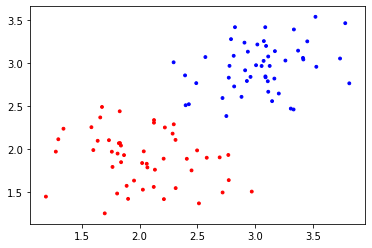

In [2]:
N1 = N2 = 50
mean_red = (2, 2)
mean_blue = (3, 3)
sigma = 0.1
cov = [[sigma, 0], [0, sigma]]

X_red = np.random.multivariate_normal(mean_red, cov, N1)
X_blue = np.random.multivariate_normal(mean_blue, cov, N2)

c1 = ['red'] * N1
c2 = ['blue'] * N2

X = np.concatenate((X_red, X_blue))
color = np.concatenate((c1, c2))

t_N = np.matrix([[0] * 50 + [1] * 50]).T

plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, s=8)
plt.show()

2. Write code to classify the two clusters with Gaussian Processes.
3. Use the kernel written on p.307 of textbook. Set the parameters to (1.0, 4.0, 1.0, 2.0)

In [3]:
def get_kernel_func(thetas):
    def k(xi, xj):
        # Convert arrays into column vectors
        xi = np.matrix(xi).T
        xj = np.matrix(xj).T
        return thetas[0] * np.exp(-thetas[1]/2 * np.linalg.norm(xi-xj)**2) + \
               thetas[2] + (thetas[3]*xi.T*xj)[0, 0]
    return k

In [12]:
X_dummy = np.insert(X, 0, 1, axis=1)

thetas = (1, 4, 1, 2)
xi = np.array([1, 1])
xj = np.array([4, 5])
k = get_kernel_func(thetas)
print(k(xi, xj))

19.0


In [5]:
def get_C(X, v, k):
    length = X.shape[0]
    C = np.zeros((length, length))
    
    for row in range(length):
        for col in range(row, length):
            if row == col:
                C[row, col] = k(X[row, ], X[row, ]) + v
            else:
                temp = k(X[row, ], X[col, ])
                C[row, col] = temp
                C[col, row] = temp
    
    return C

In [6]:
def get_c_star(x_star, v, k):
    return k(x_star, x_star) + v

In [9]:
def get_k_star(x_star, X_dummy, k):
    return np.matrix([k(x_star, x) for x in X_dummy]).T

In [7]:
def sigmoid(a):
    return 1 / (1 + np.exp(-a))

In [10]:
def get_W_N2(X, w):
    X_dummy = np.insert(X, 0, 1, axis=1)
    length = X_dummy.shape[0]
    W = np.zeros((length, length))
    
    for i in range(length):
        temp = sigmoid(X_dummy[i, ] * w)[0, 0]
        W[i, i] = temp * (1-temp)
    
    print(W)
    return None

get_W_N2(X, np.matrix([1,1,1]).T)

[[0.0074281  0.         0.         ... 0.         0.         0.        ]
 [0.         0.00422504 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00606461 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.0006831  0.         0.        ]
 [0.         0.         0.         ... 0.         0.00112244 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00082793]]


In [14]:
def get_W_N(a_N):
    temp = sigmoid(a_N)
    temp2 = 1 - temp
    
    return np.diag(np.diag(temp * temp2.T))

print(get_W_N(X_dummy * np.matrix([1, 1, 1]).T))

[[0.0074281  0.         0.         ... 0.         0.         0.        ]
 [0.         0.00422504 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00606461 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.0006831  0.         0.        ]
 [0.         0.         0.         ... 0.         0.00112244 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00082793]]


In [17]:
def get_a_N(X_dummy, t_N, C):
        w_ini = np.matrix([0, 0, 0]).T
        X_dummy = np.insert(X, 0, 1, axis=1)
        
        a_N = X_dummy * w_ini

        counter = 0
        sum_diff = 999

        while sum_diff > 1e-4:
            H = -np.linalg.inv(C) - get_W_N(a_N)
            nabla_g = t_N - sigmoid(a_N) - (np.linalg.inv(C) * a_N)

            a_N_new = a_N - (np.linalg.inv(H) * nabla_g)
            sum_diff = abs(sum(a_N_new - a_N))
            counter += 1
            
            a_N = a_N_new

        return a_N

In [24]:
def get_prob_blue(x_star, X_dummy, k, v, C, a_N, W_N_inv):
            
    k_star = get_k_star(x_star, X_dummy, k)
    c_star = get_c_star(x_star, v, k)

    mu_star = k_star.T * np.linalg.inv(C) * a_N
    s_star = c_star - (k_star.T * np.linalg.inv(W_N_inv + C) * k_star)

    return sigmoid(mu_star / np.power(1 + (s_star**2 * np.pi/8), 1/2))

In [30]:
X_dummy = np.insert(X, 0, 1, axis=1)
v = 1
thetas = (1, 4, 1, 2)
k = get_kernel_func(thetas)

# Variables that will not depend on x_star
C = get_C(X_dummy, v, k)
a_N = get_a_N(X_dummy, t_N, C)
W_N_inv = np.linalg.inv(get_W_N(a_N))

In [31]:
# Prepare values for image
n_pixels = 50

Z = np.zeros((n_pixels, n_pixels))
for col, x1 in enumerate(np.linspace(0, 5, n_pixels)):
    for row, x2 in enumerate(np.linspace(0, 5, n_pixels)):
        Z[row, col] = get_prob_blue(np.matrix([[1, x1, x2]]), X_dummy, k, v,
                                   C, a_N, W_N_inv)
        
    print("col: {}".format(col))

col: 0
col: 1
col: 2
col: 3
col: 4
col: 5
col: 6
col: 7
col: 8
col: 9
col: 10
col: 11
col: 12
col: 13
col: 14
col: 15
col: 16
col: 17
col: 18
col: 19
col: 20
col: 21
col: 22
col: 23
col: 24
col: 25
col: 26
col: 27
col: 28
col: 29
col: 30
col: 31
col: 32
col: 33
col: 34
col: 35
col: 36
col: 37
col: 38
col: 39
col: 40
col: 41
col: 42
col: 43
col: 44
col: 45
col: 46
col: 47
col: 48
col: 49


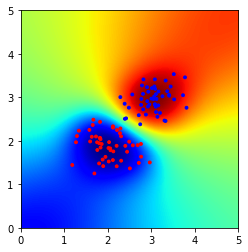

In [32]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=color, s=8)
plt.imshow(Z, interpolation='bilinear', origin='lower', cmap='jet',
           extent=[0,5,0,5])